In [2]:
###Project 3
#Setup
import os
import numpy as np
import mglearn as mgl
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.cluster import DBSCAN
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import column_or_1d
from sklearn.impute import SimpleImputer
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib as mp
import matplotlib.pyplot as plt
import ctypes
hllDll = ctypes.WinDLL("C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.7\\bin\\cudart64_110.dll")
import tensorflow as tf

###Load & format our dataset
#os.chdir("D:\School\Summer 2022\Advanced Data Analysis")
#GAMMA = pd.read_csv("magic04.data", header=None)
GAMMA = pd.read_csv("https://raw.githubusercontent.com/Disco-Gnome/DATA712/main/magic04.data",
                    sep=",")
GAMMA.columns = ['fLength','fWidth','fSize','fConc','fConc1','fAsym','fM3Long','fM3Trans','fAlpha','fDist','gamma']

#I would use LabelEncoder() here, but that encodes h=1 & g=0,
#with no simple method for remapping. I want g=1 and h=0 explicitly,
#so I create this column manually
GAMMA['gamma_enc'] = GAMMA['gamma']
GAMMA['gamma_enc'].replace({'g':"1", 'h':"0"},
                           inplace=True)
GAMMA['gamma_enc'] = GAMMA['gamma_enc'].astype(int)
GAMMA = GAMMA.drop('gamma', axis=1)

###Create Training & Testing sets
GAMMA_X = GAMMA.drop(['gamma_enc'], axis=1)
GAMMA_y = GAMMA['gamma_enc']
X_train, X_test, y_train, y_test = train_test_split(GAMMA_X,
                                                    GAMMA_y,
                                                    random_state=1,
                                                    stratify=GAMMA_y)

In [ ]:
#I tried using my own dataset for project 3, even though after analysis, it doesn't appear to lend iteself to
#PCA or cluster analysis in any combination. I would have switched to using one of the toy datasets you provided,
#but I really wanted to see if I could still uncover /anything/ in this dataset.

In [3]:
#%%
#Scale Data
scaler = StandardScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X_train)

#PCA using just our training data
pca2 = PCA(n_components=2)
pca2.fit(X_scaled)
X_pca2 = pca2.transform(X_scaled)


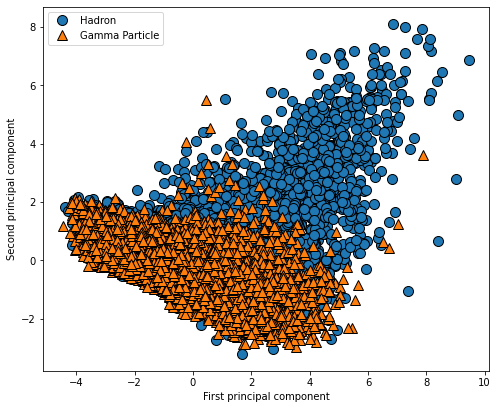

In [4]:
#PCA Scatter
plt.figure(figsize=(8, 8))
mgl.discrete_scatter(X_pca2[:, 0], X_pca2[:, 1], y_train)
plt.legend(["Hadron", "Gamma Particle"], loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()

Text(0, 0.5, 'Principal components')

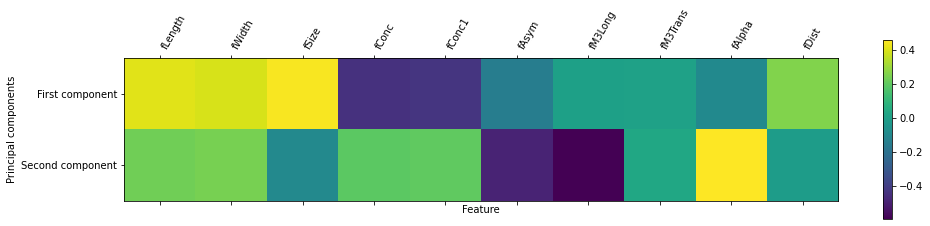

In [5]:
#PCA Matshow
plt.matshow(pca2.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(X_train.columns)),
           X_train.columns, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components")

In [7]:
#95% Explained Variance
pca95 = PCA(n_components=0.95)
pca95.fit(X_scaled)
print('-'*20 + 'Explained variance ratio' + '-'*20)
print(pca95.explained_variance_ratio_)
#We need to retain 7 components to reach 95% variance explained.

--------------------Explained variance ratio--------------------
[0.42218669 0.15825273 0.10056573 0.09934094 0.07395331 0.06557313
 0.04049463]


In [8]:
#Moving on to using our full data
X_scaled2 = scaler.transform(GAMMA_X)
cv1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
pca95 = PCA(n_components=0.95)
pca95.fit(X_scaled2)
X_pca95 = pca95.transform(X_scaled2)

for train_index, test_index in cv1.split(X_scaled2, GAMMA_y):
    X_train2 = X_pca95[train_index]
    X_test2 = X_pca95[test_index]
    y_train2 = GAMMA_y[train_index]
    y_test2 = GAMMA_y[test_index]

model = RandomForestClassifier(random_state=1).fit(X_train2, y_train2)
print("Accuracy on training set: {:.2f}".format(model.score(X_train2, y_train2)))
print("Accuracy on test set: {:.2f}".format(model.score(X_test2, y_test2)))

Accuracy on training set: 1.00
Accuracy on test set: 0.82


In [9]:
#Does this improve best performing model from project 2?
#In project 2, RF and GBRT worked comparably, both better
#than k-means. Here, I'll use our optimal RF as our optimal model.

#Optimal Model with PCA
forest_opt = RandomForestClassifier(criterion='entropy',
                                    max_depth=9,
                                    max_features=7,
                                    n_estimators=10)

forest_opt.fit(X_train, y_train)
print('-'*20 + 'Performance Without PCA' + '-'*20)
print(classification_report(y_test, forest_opt.predict(X_test),
                            target_names=["Hadron", "Gamma Particles"]))

forest_opt.fit(X_train2, y_train2)
print('-'*20 + 'Performance With PCA' + '-'*20)
print(classification_report(y_test2, forest_opt.predict(X_test2),
                            target_names=["Hadron", "Gamma Particles"]))

#PCA diminishes our best performing model, suggesting that there is meaningful
#phenomena in our omitted components which cannot be captured in those remaining

--------------------Performance Without PCA--------------------
                 precision    recall  f1-score   support

         Hadron       0.88      0.71      0.79      1672
Gamma Particles       0.86      0.95      0.90      3083

       accuracy                           0.86      4755
      macro avg       0.87      0.83      0.84      4755
   weighted avg       0.87      0.86      0.86      4755

--------------------Performance With PCA--------------------
                 precision    recall  f1-score   support

         Hadron       0.79      0.63      0.70      1338
Gamma Particles       0.82      0.91      0.86      2466

       accuracy                           0.81      3804
      macro avg       0.81      0.77      0.78      3804
   weighted avg       0.81      0.81      0.81      3804



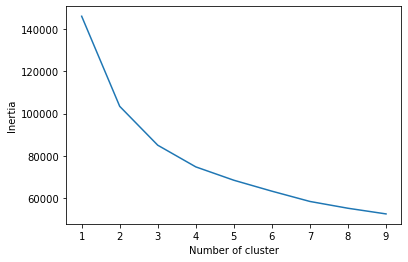

Text(0, 0.5, 'Component 2')

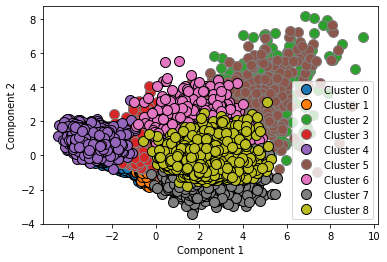

In [12]:
#k-Means with PCA
cv1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)

inertiaVals = {}
for k in range(1, 10):
    kmeansTmp = KMeans(n_clusters=k, max_iter=1000).fit(X_train2)
    inertiaVals[k] = kmeansTmp.inertia_
plt.figure()
plt.plot(list(inertiaVals.keys()), list(inertiaVals.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.show()

kmeans3 = KMeans(n_clusters=3)
kmeans3.fit(X_train2)
mgl.discrete_scatter(X_train2[:,0], X_train2[:,1], kmeans3.labels_, markers='o')
plt.legend(["Cluster 0",
            "Cluster 1",
            "Cluster 2",
            "Cluster 3",
            "Cluster 4",
            "Cluster 5",
            "Cluster 6",
            "Cluster 7",
            "Cluster 8",
            "Cluster 9"], loc="best")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

#Because of the shape of our data, the inertia curve appears to be
#relatively smooth. In reality there do not appear to be discrete
#clusters in our PCA graph. As such, I arbitrarily choose 3 clusters
#for my kmeans command. Increasing the number of clusters results in
#an increasingly difficult-to-read visualization

In [ ]:
#K-means with PCA ARI & Silhouette Coefficient


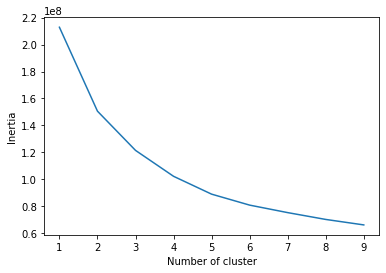

Text(0, 0.5, 'fM3Long')

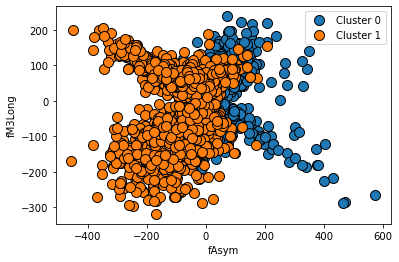

In [11]:
#k-Means without PCA
inertiaVals = {}
for k in range(1, 10):
    kmeansTmp = KMeans(n_clusters=k, max_iter=1000).fit(X_train)
    inertiaVals[k] = kmeansTmp.inertia_
plt.figure()
plt.plot(list(inertiaVals.keys()), list(inertiaVals.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.show()

kmeans2 = KMeans(n_clusters=2)
kmeans2.fit(X_train)
mgl.discrete_scatter(X_train["fAsym"], X_train["fM3Long"], kmeans2.labels_, markers='o')
plt.legend(["Cluster 0",
            "Cluster 1",
            "Cluster 2",
            "Cluster 3",
            "Cluster 4",
            "Cluster 5",
            "Cluster 6",
            "Cluster 7",
            "Cluster 8",
            "Cluster 9"], loc="best")
plt.xlabel("fAsym")
plt.ylabel("fM3Long")

In [ ]:
#K-means without PCA ARI & Silhouette Coefficient


In [ ]:
#Agglomerate/Hierarchical with PCA
agg = AgglomerativeClustering(n_clusters=3)
assignment = agg.fit_predict(X_train2)

mgl.discrete_scatter(X_train2[:,0], X_train2[:,1], assignment)
plt.legend(["Cluster 0",
            "Cluster 1",
            "Cluster 2",
            "Cluster 3",
            "Cluster 4",
            "Cluster 5",
            "Cluster 6",
            "Cluster 7",
            "Cluster 8",
            "Cluster 9"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

linkage_array = ward(X_train2)
dendrogram(linkage_array)
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")
plt.show()

linkage_array = ward(X_train2)
dendrogram(linkage_array)
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")
plt.show()

In [ ]:
#Agglomerate/Hierarchical with PCA ARI & Silhouette Coefficient


In [ ]:
#Agglomerate/Hierarchical without PCA
agg = AgglomerativeClustering(n_clusters=4)
assignment = agg.fit_predict(X_train)

mgl.discrete_scatter(X_train["fAsym"], X_train["fM3Long"], assignment)
plt.legend(["Cluster 0",
            "Cluster 1",
            "Cluster 2",
            "Cluster 3",
            "Cluster 4",
            "Cluster 5",
            "Cluster 6",
            "Cluster 7",
            "Cluster 8",
            "Cluster 9"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

linkage_array = ward(X_train)
dendrogram(linkage_array)
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")
plt.show()

In [ ]:
#Agglomerate/Hierarchical without PCA ARI & Silhouette Coefficient


In [ ]:
#DBSCAN with PCA
dbscan = DBSCAN(min_samples=2,eps=0.5)
clusters = dbscan.fit_predict(X_train2)

plt.scatter(X_train2[:,0], X_train2[:,1], c=clusters, cmap=mgl.cm2, s=80, alpha=0.1)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

mgl.discrete_scatter(X_train2[:, 0], X_train2[:, 1], clusters, s=9, alpha=0.5)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 5"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()


In [ ]:
#DBSCAN with PCA ARI & Silhouette Coefficient


In [ ]:
#DBSCAN without PCA
dbscan = DBSCAN(min_samples=2, eps=0.5)
clusters = dbscan.fit_predict(X_train)

plt.scatter(X_train["fAsym"], X_train["fM3Long"], c=clusters, cmap=mgl.cm2, s=80, alpha=0.2)
plt.xlabel("fAsym")
plt.ylabel("fM3Long")

mgl.discrete_scatter(X_train["fAsym"], X_train["fM3Long"], clusters, s=9, alpha=0.5)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 5"], loc="best")
plt.xlabel("fAsym")
plt.ylabel("fM3Long")

In [ ]:
#DBSCAN without PCA ARI & Silhouette Coefficient
